Found 26395 variants and 745 samples
Converting genotypes...


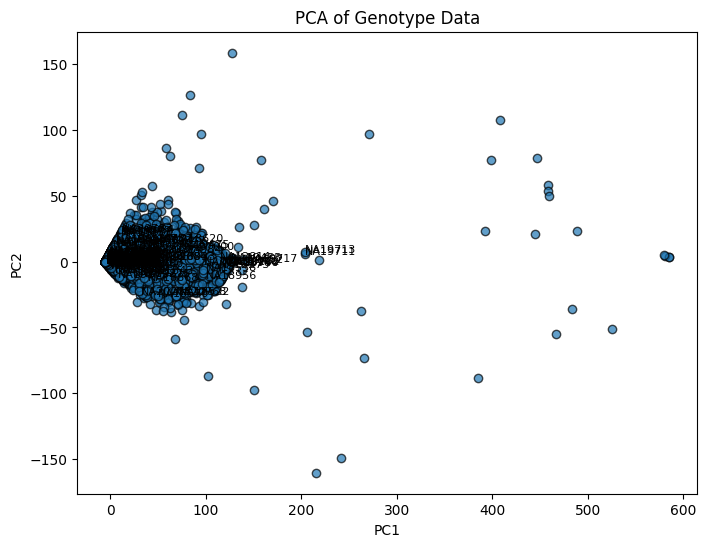

In [2]:
import subprocess
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os 
# Step 1: Load VCF file and extract genotype data

def load_vcf_and_genotypes(vcf_file, output_array=True):
    """
    Load VCF file and extract genotype data (GT)
    
    Parameters:
    -----------
    vcf_file : str
        Path to the VCF file
    output_array : bool
        If True, returns a numpy array for genotypes
    """
    # Extract number of variants and samples
    cmd = f"bcftools view -H {vcf_file} | wc -l"
    n_variants = int(subprocess.check_output(cmd, shell=True).decode().strip())
    
    cmd = f"bcftools query -l {vcf_file} | wc -l"
    n_samples = int(subprocess.check_output(cmd, shell=True).decode().strip())
    
    print(f"Found {n_variants} variants and {n_samples} samples")
    
    # Initialize masked array if needed
    if output_array:
        geno_array = np.ma.empty((n_variants, n_samples), dtype=np.uint8)
        geno_array.mask = False  # Initialize mask

    # Extract and convert genotypes
    cmd = f"bcftools query -f '%CHROM\t%POS[\t%GT]' {vcf_file} > temp_geno.txt"
    subprocess.run(cmd, shell=True, check=True)
    
    print("Converting genotypes...")
    with open('temp_geno.txt', 'r') as f:
        for i, line in enumerate(f):
            parts = line.strip().split('\t')
            gts = parts[2:]  # Skip CHROM and POS

            converted = []
            for j, gt in enumerate(gts):
                if gt in ['0|0', '0/0']:
                    code = 0
                elif gt in ['0|1', '1|0', '0/1', '1/0']:
                    code = 1
                elif gt in ['1|1', '1/1']:
                    code = 2
                else:
                    code = 9  # Missing value
                    if output_array:
                        geno_array.mask[i, j] = True

                converted.append(str(code))
                if output_array:
                    geno_array[i, j] = code

    os.remove('temp_geno.txt')
    
    if output_array:
        return geno_array
    return None

# Step 2: Extract sample names from VCF file (without using .ind file)

def get_sample_names(vcf_file):
    """
    Extract sample names from VCF file header
    """
    cmd = f"bcftools query -l {vcf_file}"
    sample_names = subprocess.check_output(cmd, shell=True).decode().splitlines()
    return sample_names

# Step 3: Standardize and perform PCA

def perform_pca(geno_array, n_components=2):
    """
    Perform PCA on the genotype array
    """
    # Standardize the data
    scaler = StandardScaler()
    scaled_geno_array = scaler.fit_transform(geno_array)
    
    # Perform PCA
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(scaled_geno_array)
    
    return pca_result

# Step 4: Plot PCA result

def plot_pca(pca_result, sample_names):
    """
    Plot the PCA result
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.7, edgecolors='k')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('PCA of Genotype Data')
    
    # Optionally, label points with sample names (if needed)
    for i, name in enumerate(sample_names):
        plt.annotate(name, (pca_result[i, 0], pca_result[i, 1]), fontsize=8)
    
    plt.show()

# Main function to run everything

def main():
    vcf_file = "../data/1000g/merged_common_snps.vcf.gz"  # Path to VCF file
    
    # Step 1: Load genotypes
    geno_array = load_vcf_and_genotypes(vcf_file, output_array=True)
    
    # Step 2: Extract sample names from VCF header
    sample_names = get_sample_names(vcf_file)
    
    # Step 3: Perform PCA
    pca_result = perform_pca(geno_array, n_components=2)
    
    # Step 4: Plot PCA results
    plot_pca(pca_result, sample_names)

if __name__ == "__main__":
    main()


Found 26395 variants and 745 samples
Converting genotypes...


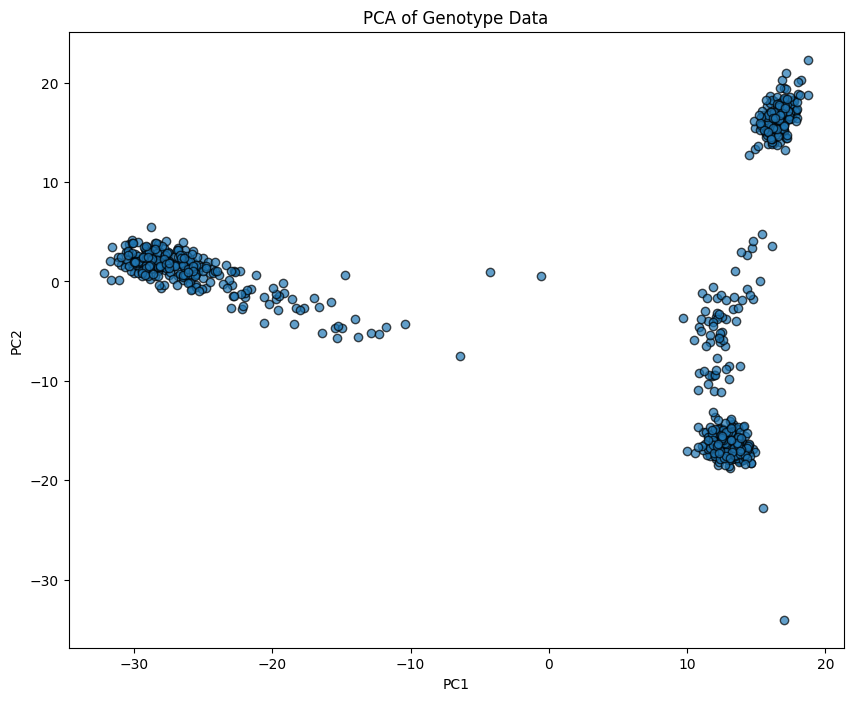

In [3]:
import subprocess
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 步骤 1：加载 VCF 文件并提取基因型数据
def load_vcf_and_genotypes(vcf_file, output_array=True):
    # 提取变异数量和样本数量
    cmd = f"bcftools view -H {vcf_file} | wc -l"
    n_variants = int(subprocess.check_output(cmd, shell=True).decode().strip())
    
    cmd = f"bcftools query -l {vcf_file} | wc -l"
    n_samples = int(subprocess.check_output(cmd, shell=True).decode().strip())
    
    print(f"Found {n_variants} variants and {n_samples} samples")
    
    # 初始化基因型矩阵
    if output_array:
        geno_array = np.ma.empty((n_samples, n_variants), dtype=np.uint8)
        geno_array.mask = False  # 初始化掩码
    
    # 提取并转换基因型
    cmd = f"bcftools query -f '%CHROM\\t%POS[\\t%GT]\\n' {vcf_file} > temp_geno.txt"
    subprocess.run(cmd, shell=True, check=True)
    
    print("Converting genotypes...")
    with open('temp_geno.txt', 'r') as f:
        for idx, line in enumerate(f):
            parts = line.strip().split('\t')
            gts = parts[2:]  # 跳过 CHROM 和 POS
            for i, gt in enumerate(gts):
                if gt in ['0|0', '0/0']:
                    code = 0
                elif gt in ['0|1', '1|0', '0/1', '1/0']:
                    code = 1
                elif gt in ['1|1', '1/1']:
                    code = 2
                else:
                    code = 9  # 缺失值
                    if output_array:
                        geno_array.mask[i, idx] = True
                if output_array:
                    geno_array[i, idx] = code
    subprocess.run("rm temp_geno.txt", shell=True)
    if output_array:
        return geno_array
    return None

# 步骤 2：从 VCF 文件中提取样本名称
def get_sample_names(vcf_file):
    cmd = f"bcftools query -l {vcf_file}"
    sample_names = subprocess.check_output(cmd, shell=True).decode().splitlines()
    return sample_names

# 步骤 3：标准化并执行 PCA
def perform_pca(geno_array, n_components=2):
    # 将缺失值替换为列平均值
    #geno_array = geno_array.filled(np.nan)
    col_means = np.nanmean(geno_array, axis=0)
    idxs = np.where(np.isnan(geno_array))
    geno_array[idxs] = np.take(col_means, idxs[1])
    
    # 标准化数据
    scaler = StandardScaler()
    scaled_geno_array = scaler.fit_transform(geno_array)
    
    # 执行 PCA
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(scaled_geno_array)
    
    return pca_result

# 步骤 4：绘制 PCA 结果并只标注远离中心的点
def plot_pca(pca_result, sample_names):
    """
    绘制 PCA 结果，并只标注远离中心的点。

    只标注满足 PC1 > 200 或 |PC2| > 75 的样本。
    """
    plt.figure(figsize=(10, 8))
    plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.7, edgecolors='k')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('PCA of Genotype Data')

    # 标注远离中心的点
    for i, (x, y) in enumerate(pca_result):
        if x > 200 or abs(y) > 75:
            plt.annotate(sample_names[i], (x, y), fontsize=8)

    plt.show()

# 主函数
def main():
    vcf_file = "../data/1000g/merged_common_snps.vcf.gz"  # VCF 文件路径

    # 步骤 1：加载基因型数据
    geno_array = load_vcf_and_genotypes(vcf_file, output_array=True)

    # 步骤 2：提取样本名称
    sample_names = get_sample_names(vcf_file)

    # 步骤 3：执行 PCA 分析
    pca_result = perform_pca(geno_array, n_components=2)

    # 步骤 4：绘制 PCA 结果
    plot_pca(pca_result, sample_names)

if __name__ == "__main__":
    main()


In [4]:
import subprocess
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 步骤 1：加载 VCF 文件并提取基因型数据
def load_vcf_and_genotypes(vcf_file, output_array=True):
    cmd = f"bcftools view -H {vcf_file} | wc -l"
    n_variants = int(subprocess.check_output(cmd, shell=True).decode().strip())
    cmd = f"bcftools query -l {vcf_file} | wc -l"
    n_samples = int(subprocess.check_output(cmd, shell=True).decode().strip())
    print(f"Found {n_variants} variants and {n_samples} samples")
    
    if output_array:
        geno_array = np.ma.empty((n_samples, n_variants), dtype=np.uint8)
        geno_array.mask = False  # 初始化掩码

    cmd = f"bcftools query -f '%CHROM\\t%POS[\\t%GT]\\n' {vcf_file} > temp_geno.txt"
    subprocess.run(cmd, shell=True, check=True)

    print("Converting genotypes...")
    with open('temp_geno.txt', 'r') as f:
        for idx, line in enumerate(f):
            parts = line.strip().split('\t')
            gts = parts[2:]  # 跳过 CHROM 和 POS
            for i, gt in enumerate(gts):
                if gt in ['0|0', '0/0']:
                    code = 0
                elif gt in ['0|1', '1|0', '0/1', '1/0']:
                    code = 1
                elif gt in ['1|1', '1/1']:
                    code = 2
                else:
                    code = 9  # 缺失值
                    if output_array:
                        geno_array.mask[i, idx] = True
                if output_array:
                    geno_array[i, idx] = code
    subprocess.run("rm temp_geno.txt", shell=True)
    if output_array:
        return geno_array
    return None

# 步骤 2：从 VCF 文件中提取样本名称
def get_sample_names(vcf_file):
    cmd = f"bcftools query -l {vcf_file}"
    sample_names = subprocess.check_output(cmd, shell=True).decode().splitlines()
    return sample_names

# 步骤 3：标准化并执行 PCA
def perform_pca(geno_array, n_components=2):
    col_means = np.nanmean(geno_array, axis=0)
    idxs = np.where(np.isnan(geno_array))
    geno_array[idxs] = np.take(col_means, idxs[1])
    scaler = StandardScaler()
    scaled_geno_array = scaler.fit_transform(geno_array)
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(scaled_geno_array)
    return pca_result

# 步骤 4：绘制 PCA 结果并按样本信息标记
def plot_pca_with_info(pca_result, sample_info, sample_names):
    plt.figure(figsize=(10, 8))
    populations = sample_info['super_population'].unique()
    colors = plt.cm.tab10(np.linspace(0, 1, len(populations)))
    pop_color_map = dict(zip(populations, colors))

    for pop in populations:
        subset = sample_info[sample_info['super_population'] == pop]
        indices = subset.index
        plt.scatter(pca_result[indices, 0], pca_result[indices, 1],
                    label=pop, alpha=0.7, edgecolors='k', c=pop_color_map[pop])

    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('PCA of Genotype Data')
    plt.legend()

    # 标注远离中心的样本
    for i, (x, y) in enumerate(pca_result):
        if x > 200 or abs(y) > 75:
            plt.annotate(sample_names[i], (x, y), fontsize=8)

    plt.show()

# 主函数
def main():
    vcf_file = "../data/1000g/merged_common_snps.vcf.gz"  # VCF 文件路径
    sample_info_file = "../data/1000g/20130606_sample_info.txt"  # 样本信息文件路径

    # 步骤 1：加载基因型数据
    geno_array = load_vcf_and_genotypes(vcf_file, output_array=True)

    # 步骤 2：提取样本名称
    sample_names = get_sample_names(vcf_file)

    # 步骤 3：加载样本信息
    sample_info = pd.read_csv(sample_info_file, sep='\t')
    sample_info = sample_info[sample_info['Sample'].isin(sample_names)]
    sample_info = sample_info.set_index('Sample').reindex(sample_names).reset_index()

    # 步骤 4：执行 PCA 分析
    pca_result = perform_pca(geno_array, n_components=2)

    # 步骤 5：绘制 PCA 结果
    plot_pca_with_info(pca_result, sample_info, sample_names)

if __name__ == "__main__":
    main()


Found 26395 variants and 745 samples
Converting genotypes...


KeyError: 'super_population'

<Figure size 1000x800 with 0 Axes>

Found 26395 variants and 745 samples
Converting genotypes...
Columns in sample_info: Index(['Sample', 'Family ID', 'Population', 'Population Description', 'Gender',
       'Relationship', 'Unexpected Parent/Child ', 'Non Paternity', 'Siblings',
       'Grandparents', 'Avuncular', 'Half Siblings', 'Unknown Second Order',
       'Third Order', 'Other Comments', 'In Low Coverage Pilot',
       'LC Pilot Platforms', 'LC Pilot Centers', 'In High Coverage Pilot',
       'HC Pilot Platforms', 'HC Pilot Centers', 'In Exon Targetted Pilot',
       'ET Pilot Platforms', 'ET Pilot Centers', 'Has Sequence in Phase1',
       'Phase1 LC Platform', 'Phase1 LC Centers', 'Phase1 E Platform',
       'Phase1 E Centers', 'In Phase1 Integrated Variant Set',
       'Has Phase1 chrY SNPS', 'Has phase1 chrY Deletions',
       'Has phase1 chrMT SNPs', 'Main project LC Centers',
       'Main project LC platform', 'Total LC Sequence',
       'LC Non Duplicated Aligned Coverage', 'Main Project E Centers',
       

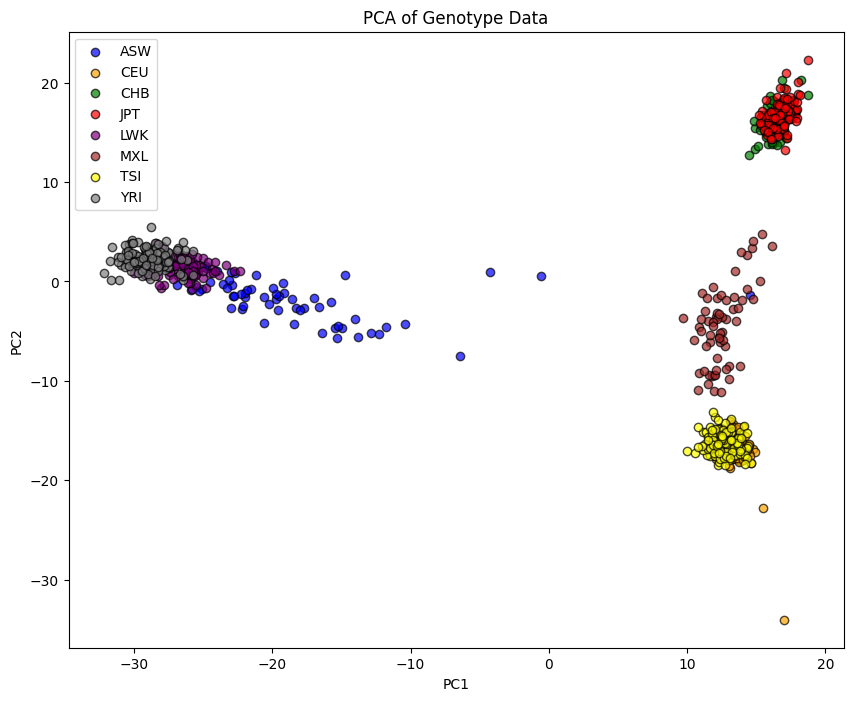

In [7]:
import subprocess
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 步骤 1：加载 VCF 文件并提取基因型数据
def load_vcf_and_genotypes(vcf_file, output_array=True):
    cmd = f"bcftools view -H {vcf_file} | wc -l"
    n_variants = int(subprocess.check_output(cmd, shell=True).decode().strip())
    cmd = f"bcftools query -l {vcf_file} | wc -l"
    n_samples = int(subprocess.check_output(cmd, shell=True).decode().strip())
    print(f"Found {n_variants} variants and {n_samples} samples")
    
    if output_array:
        geno_array = np.ma.empty((n_samples, n_variants), dtype=np.uint8)
        geno_array.mask = False  # 初始化掩码

    cmd = f"bcftools query -f '%CHROM\\t%POS[\\t%GT]\\n' {vcf_file} > temp_geno.txt"
    subprocess.run(cmd, shell=True, check=True)

    print("Converting genotypes...")
    with open('temp_geno.txt', 'r') as f:
        for idx, line in enumerate(f):
            parts = line.strip().split('\t')
            gts = parts[2:]  # 跳过 CHROM 和 POS
            for i, gt in enumerate(gts):
                if gt in ['0|0', '0/0']:
                    code = 0
                elif gt in ['0|1', '1|0', '0/1', '1/0']:
                    code = 1
                elif gt in ['1|1', '1/1']:
                    code = 2
                else:
                    code = 9  # 缺失值
                    if output_array:
                        geno_array.mask[i, idx] = True
                if output_array:
                    geno_array[i, idx] = code
    subprocess.run("rm temp_geno.txt", shell=True)
    if output_array:
        return geno_array
    return None

# 步骤 2：从 VCF 文件中提取样本名称
def get_sample_names(vcf_file):
    cmd = f"bcftools query -l {vcf_file}"
    sample_names = subprocess.check_output(cmd, shell=True).decode().splitlines()
    return sample_names

# 步骤 3：标准化并执行 PCA
def perform_pca(geno_array, n_components=2):
    col_means = np.nanmean(geno_array, axis=0)
    idxs = np.where(np.isnan(geno_array))
    geno_array[idxs] = np.take(col_means, idxs[1])
    scaler = StandardScaler()
    scaled_geno_array = scaler.fit_transform(geno_array)
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(scaled_geno_array)
    return pca_result

# 步骤 4：绘制 PCA 结果并按样本信息标记
def plot_pca_with_info(pca_result, sample_info, sample_names):
    plt.figure(figsize=(10, 8))

    # Use the "Population" column for grouping
    if 'Population' in sample_info.columns:
        grouping_column = 'Population'
    else:
        raise KeyError("The required column for population grouping (e.g., 'Population') is not found.")

    # Define specific colors to match the reference plot
    color_palette = {
        'ASW': 'blue',
        'CEU': 'orange',
        'CHB': 'green',
        'JPT': 'red',
        'LWK': 'purple',
        'MXL': 'brown',
        'TSI': 'yellow',
        'YRI': 'gray'
    }

    # Plot each population with its specific color
    for pop, color in color_palette.items():
        if pop in sample_info[grouping_column].values:
            subset = sample_info[sample_info[grouping_column] == pop]
            indices = subset.index
            plt.scatter(
                pca_result[indices, 0], 
                pca_result[indices, 1],
                label=pop, 
                color=color, 
                alpha=0.7, 
                edgecolors='k'
            )

    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('PCA of Genotype Data')
    plt.legend()
    #plt.grid(True)
    plt.show()

# 主函数
def main():
    vcf_file = "../data/1000g/merged_common_snps.vcf.gz"  # VCF 文件路径
    sample_info_file = "../data/1000g/20130606_sample_info.txt"  # 样本信息文件路径

    # 步骤 1：加载基因型数据
    geno_array = load_vcf_and_genotypes(vcf_file, output_array=True)

    # 步骤 2：提取样本名称
    sample_names = get_sample_names(vcf_file)

    # 步骤 3：加载样本信息
    sample_info = pd.read_csv(sample_info_file, sep='\t')
    print("Columns in sample_info:", sample_info.columns)  # Debug: 检查列名

    # 确保列名无空格
    sample_info.columns = sample_info.columns.str.strip()

    # 根据 sample_names 筛选样本信息
    sample_info = sample_info[sample_info['Sample'].isin(sample_names)]
    sample_info = sample_info.set_index('Sample').reindex(sample_names).reset_index()

    # 步骤 4：执行 PCA 分析
    pca_result = perform_pca(geno_array, n_components=2)

    # 步骤 5：绘制 PCA 结果
    plot_pca_with_info(pca_result, sample_info, sample_names)

if __name__ == "__main__":
    main()


Found 26395 variants and 745 samples
Converting genotypes...
Explained variance ratio: [0.02601974 0.01060135]
Filtered 3 outliers based on coordinates.


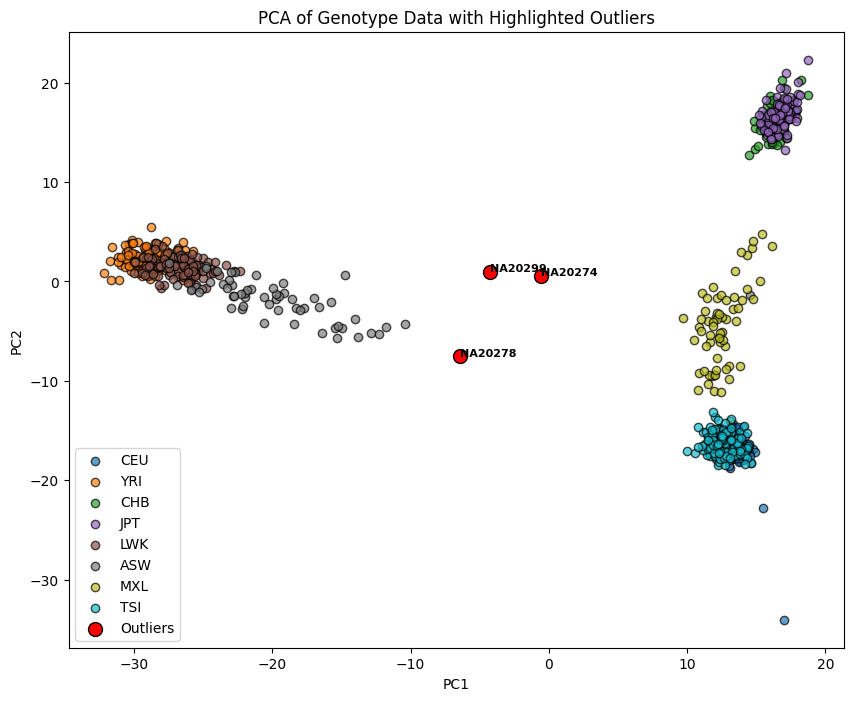

In [5]:
import subprocess
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 步骤 1：加载 VCF 文件并提取基因型数据
def load_vcf_and_genotypes(vcf_file, output_array=True):
    cmd = f"bcftools view -H {vcf_file} | wc -l"
    n_variants = int(subprocess.check_output(cmd, shell=True).decode().strip())
    cmd = f"bcftools query -l {vcf_file} | wc -l"
    n_samples = int(subprocess.check_output(cmd, shell=True).decode().strip())
    print(f"Found {n_variants} variants and {n_samples} samples")
    
    if output_array:
        geno_array = np.ma.empty((n_samples, n_variants), dtype=np.uint8)
        geno_array.mask = False  # 初始化掩码

    cmd = f"bcftools query -f '%CHROM\\t%POS[\\t%GT]\\n' {vcf_file} > temp_geno.txt"
    subprocess.run(cmd, shell=True, check=True)

    print("Converting genotypes...")
    snp_info = []
    with open('temp_geno.txt', 'r') as f:
        for idx, line in enumerate(f):
            parts = line.strip().split('\t')
            snp_info.append(parts[:2])  # 保存 CHROM 和 POS 信息
            gts = parts[2:]  # 跳过 CHROM 和 POS
            for i, gt in enumerate(gts):
                if gt in ['0|0', '0/0']:
                    code = 0
                elif gt in ['0|1', '1|0', '0/1', '1/0']:
                    code = 1
                elif gt in ['1|1', '1/1']:
                    code = 2
                else:
                    code = 9  # 缺失值
                    if output_array:
                        geno_array.mask[i, idx] = True
                if output_array:
                    geno_array[i, idx] = code
    subprocess.run("rm temp_geno.txt", shell=True)
    if output_array:
        return geno_array, snp_info
    return None, snp_info

# 步骤 2：执行 PCA 分析
def perform_pca(geno_array, n_components=2):
    """
    标准化数据并执行 PCA。
    """
    # 将缺失值（NaN）替换为列均值
    col_means = np.nanmean(geno_array, axis=0)
    idxs = np.where(np.isnan(geno_array))
    geno_array[idxs] = np.take(col_means, idxs[1])

    # 标准化数据
    scaler = StandardScaler()
    scaled_geno_array = scaler.fit_transform(geno_array)

    # 执行 PCA
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(scaled_geno_array)

    print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
    return pca_result

# 步骤 3：根据绝对坐标过滤离群点
def filter_outliers_by_coordinates(pca_result, coord_thresholds):
    """
    根据 PCA 结果的绝对坐标过滤离群点。
    :param pca_result: PCA 转换后的数据
    :param coord_thresholds: 坐标过滤条件 (dict)，如 {'PC1_min': -30, 'PC1_max': 20, 'PC2_min': -30, 'PC2_max': 10}
    :return: 满足条件的离群点索引
    """
    indices = np.where(
        (pca_result[:, 0] < coord_thresholds['PC1_max']) &
        (pca_result[:, 0] > coord_thresholds['PC1_min']) &
        (pca_result[:, 1] < coord_thresholds['PC2_max']) &
        (pca_result[:, 1] > coord_thresholds['PC2_min'])
    )[0]
    print(f"Filtered {len(indices)} outliers based on coordinates.")
    return indices

# 步骤 4：绘制 PCA 结果并标注离群点
def plot_pca_with_outliers_and_labels(pca_result, sample_info, outliers, labels):
    """
    绘制 PCA 结果，并在离群点处添加标注。
    """
    plt.figure(figsize=(10, 8))

    # 绘制所有点
    populations = sample_info['Population'].unique()
    colors = plt.cm.tab10(np.linspace(0, 1, len(populations)))
    pop_color_map = dict(zip(populations, colors))

    for pop in populations:
        subset = sample_info[sample_info['Population'] == pop]
        indices = subset.index
        plt.scatter(pca_result[indices, 0], pca_result[indices, 1],
                    label=pop, alpha=0.7, edgecolors='k', c=[pop_color_map[pop]])

    # 标记离群点
    plt.scatter(pca_result[outliers, 0], pca_result[outliers, 1],
                color='red', label='Outliers', edgecolors='k', s=100)

    # 为离群点添加标注
    for i, idx in enumerate(outliers):
        plt.annotate(labels[i], (pca_result[idx, 0], pca_result[idx, 1]),
                     fontsize=8, color='black', weight='bold')

    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('PCA of Genotype Data with Highlighted Outliers')
    plt.legend()
    plt.show()

# 主函数
def main():
    vcf_file = "../data/1000g/merged_common_snps.vcf.gz"
    sample_info_file = "../data/1000g/20130606_sample_info.txt"

    # 步骤 1：加载基因型数据
    geno_array, snp_info = load_vcf_and_genotypes(vcf_file, output_array=True)

    # 步骤 2：提取样本名称
    sample_names = subprocess.check_output(f"bcftools query -l {vcf_file}", shell=True).decode().splitlines()

    # 步骤 3：加载样本信息
    sample_info = pd.read_csv(sample_info_file, sep='\t')
    sample_info.columns = sample_info.columns.str.strip()
    sample_info = sample_info[sample_info['Sample'].isin(sample_names)]
    sample_info = sample_info.set_index('Sample').reindex(sample_names).reset_index()

    # 步骤 4：执行 PCA 分析
    pca_result = perform_pca(geno_array, n_components=2)

    # 步骤 5：根据坐标过滤离群点
    coord_thresholds = {
        'PC1_min': -9, 'PC1_max': 5,  # PC1 坐标范围
        'PC2_min': -30, 'PC2_max': 10   # PC2 坐标范围
    }
    outlier_indices = filter_outliers_by_coordinates(pca_result, coord_thresholds)

    # 提取离群点对应的样本名（或 SNP 信息）
    outlier_labels = [sample_names[i] for i in outlier_indices]

    # 步骤 6：绘制包含标注的 PCA 图
    plot_pca_with_outliers_and_labels(pca_result, sample_info, outlier_indices, outlier_labels)

if __name__ == "__main__":
    main()


In [8]:
import subprocess
import numpy as np

def extract_allele_frequencies(vcf_file, sample_indices):
    """
    Extract allele frequencies from a VCF file for the given sample indices.
    :param vcf_file: Path to the VCF file
    :param sample_indices: Indices of the samples to calculate frequencies for
    :return: Allele frequencies for each SNP
    """
    print("Extracting allele frequencies...")

    # Query genotype data for the required samples
    cmd = f"bcftools query -f '[%GT\\t]\\n' -s {','.join(map(str, sample_indices))} {vcf_file} > temp_genotypes.txt"
    subprocess.run(cmd, shell=True, check=True)

    allele_frequencies = []
    with open("temp_genotypes.txt", "r") as f:
        for line in f:
            genotypes = line.strip().split("\t")
            total_alleles = 0
            alt_alleles = 0
            for gt in genotypes:
                if gt in ["0|0", "0/0"]:
                    total_alleles += 2
                elif gt in ["0|1", "1|0", "0/1", "1/0"]:
                    total_alleles += 2
                    alt_alleles += 1
                elif gt in ["1|1", "1/1"]:
                    total_alleles += 2
                    alt_alleles += 2
            allele_frequencies.append(alt_alleles / total_alleles if total_alleles > 0 else 0.0)

    # Remove temporary file
    subprocess.run("rm temp_genotypes.txt", shell=True)
    return np.array(allele_frequencies)

def calculate_fst(pop1_freq, pop2_freq):
    """
    Calculate FST using Hudson's estimator.
    :param pop1_freq: Allele frequencies in population 1 (1D array)
    :param pop2_freq: Allele frequencies in population 2 (1D array)
    :return: FST value
    """
    # Mean allele frequency across populations
    p_mean = (pop1_freq + pop2_freq) / 2

    # Variance between populations
    var_between = (pop1_freq - pop2_freq) ** 2

    # Variance within populations
    var_within = 2 * p_mean * (1 - p_mean)

    fst = np.sum(var_between) / (np.sum(var_between) + np.sum(var_within))
    return fst

def main():
    # Step 1: Input files and populations
    vcf_file = "../data/1000g/merged_common_snps.vcf.gz"
    sample_info_file = "../data/1000g/20130606_sample_info.txt"

    # Load sample information
    sample_info = pd.read_csv(sample_info_file, sep="\t")
    pop1_samples = sample_info[sample_info['Population'] == 'CEU']['Sample'].tolist()
    pop2_samples = sample_info[sample_info['Population'] == 'YRI']['Sample'].tolist()

    # Step 2: Get sample list from VCF
    cmd = f"bcftools query -l {vcf_file}"
    all_samples = subprocess.check_output(cmd, shell=True).decode().splitlines()

    # Step 3: Filter samples to match VCF
    pop1_samples = [sample for sample in pop1_samples if sample in all_samples]
    pop2_samples = [sample for sample in pop2_samples if sample in all_samples]

    # Step 4: Extract allele frequencies and calculate FST
    pop1_freq = extract_allele_frequencies(vcf_file, pop1_samples)
    pop2_freq = extract_allele_frequencies(vcf_file, pop2_samples)
    fst_value = calculate_fst(pop1_freq, pop2_freq)

    # Step 5: Output FST result
    print(f"FST value between population 1 and population 2: {fst_value}")

if __name__ == "__main__":
    main()


Extracting allele frequencies...
Extracting allele frequencies...
FST value between population 1 and population 2: 0.13102420955735067


In [3]:
import subprocess
import numpy as np
import pandas as pd
from itertools import combinations

def extract_allele_frequencies(vcf_file, sample_indices):
    """
    Extract allele frequencies from a VCF file for the given sample indices.
    :param vcf_file: Path to the VCF file
    :param sample_indices: Indices of the samples to calculate frequencies for
    :return: Allele frequencies for each SNP
    """
    print("Extracting allele frequencies...")

    # Query genotype data for the required samples
    cmd = f"bcftools query -f '[%GT\\t]\\n' -s {','.join(map(str, sample_indices))} {vcf_file} > temp_genotypes.txt"
    subprocess.run(cmd, shell=True, check=True)

    allele_frequencies = []
    with open("temp_genotypes.txt", "r") as f:
        for line in f:
            genotypes = line.strip().split("\t")
            total_alleles = 0
            alt_alleles = 0
            for gt in genotypes:
                if gt in ["0|0", "0/0"]:
                    total_alleles += 2
                elif gt in ["0|1", "1|0", "0/1", "1/0"]:
                    total_alleles += 2
                    alt_alleles += 1
                elif gt in ["1|1", "1/1"]:
                    total_alleles += 2
                    alt_alleles += 2
            allele_frequencies.append(alt_alleles / total_alleles if total_alleles > 0 else 0.0)

    # Remove temporary file
    subprocess.run("rm temp_genotypes.txt", shell=True)
    return np.array(allele_frequencies)

def calculate_fst(pop1_freq, pop2_freq):
    """
    Calculate FST using Hudson's estimator.
    :param pop1_freq: Allele frequencies in population 1 (1D array)
    :param pop2_freq: Allele frequencies in population 2 (1D array)
    :return: FST value
    """
    # Mean allele frequency across populations
    p_mean = (pop1_freq + pop2_freq) / 2

    # Variance between populations
    var_between = (pop1_freq - pop2_freq) ** 2

    # Variance within populations
    var_within = 2 * p_mean * (1 - p_mean)

    fst = np.sum(var_between) / (np.sum(var_between) + np.sum(var_within))
    return fst

def main():
    # Step 1: Input files and populations
    vcf_file = "../data/1000g/merged_common_snps.vcf.gz"
    sample_info_file = "../data/1000g/20130606_sample_info.txt"

    # Target populations
    populations = ['CEU', 'YRI', 'CHB', 'JPT', 'LWK', 'ASW', 'MXL', 'TSI']

    # Load sample information
    sample_info = pd.read_csv(sample_info_file, sep="\t")
    pop_samples = {
        pop: sample_info[sample_info['Population'] == pop]['Sample'].tolist()
        for pop in populations
    }

    # Step 2: Get sample list from VCF
    cmd = f"bcftools query -l {vcf_file}"
    all_samples = subprocess.check_output(cmd, shell=True).decode().splitlines()

    # Filter samples to match VCF
    for pop in populations:
        pop_samples[pop] = [sample for sample in pop_samples[pop] if sample in all_samples]

    # Step 3: Calculate FST for all pairs of populations
    results = []
    for pop1, pop2 in combinations(populations, 2):
        print(f"Calculating FST for {pop1} and {pop2}...")
        pop1_freq = extract_allele_frequencies(vcf_file, pop_samples[pop1])
        pop2_freq = extract_allele_frequencies(vcf_file, pop_samples[pop2])
        fst_value = calculate_fst(pop1_freq, pop2_freq)
        num_snps = len(pop1_freq)
        results.append({'Population 1': pop1, 'Population 2': pop2, 'FST': fst_value, 'SNP Count': num_snps})

    # Step 4: Save results to a DataFrame and output
    results_df = pd.DataFrame(results)
    results_df.to_csv("population_fst_results.csv", index=False)
    print("Results saved to population_fst_results.csv")
    print(results_df)

if __name__ == "__main__":
    main()


Calculating FST for CEU and YRI...
Extracting allele frequencies...
Extracting allele frequencies...
Calculating FST for CEU and CHB...
Extracting allele frequencies...
Extracting allele frequencies...
Calculating FST for CEU and JPT...
Extracting allele frequencies...
Extracting allele frequencies...
Calculating FST for CEU and LWK...
Extracting allele frequencies...
Extracting allele frequencies...
Calculating FST for CEU and ASW...
Extracting allele frequencies...
Extracting allele frequencies...
Calculating FST for CEU and MXL...
Extracting allele frequencies...
Extracting allele frequencies...
Calculating FST for CEU and TSI...
Extracting allele frequencies...
Extracting allele frequencies...
Calculating FST for YRI and CHB...
Extracting allele frequencies...
Extracting allele frequencies...
Calculating FST for YRI and JPT...
Extracting allele frequencies...
Extracting allele frequencies...
Calculating FST for YRI and LWK...
Extracting allele frequencies...
Extracting allele frequ

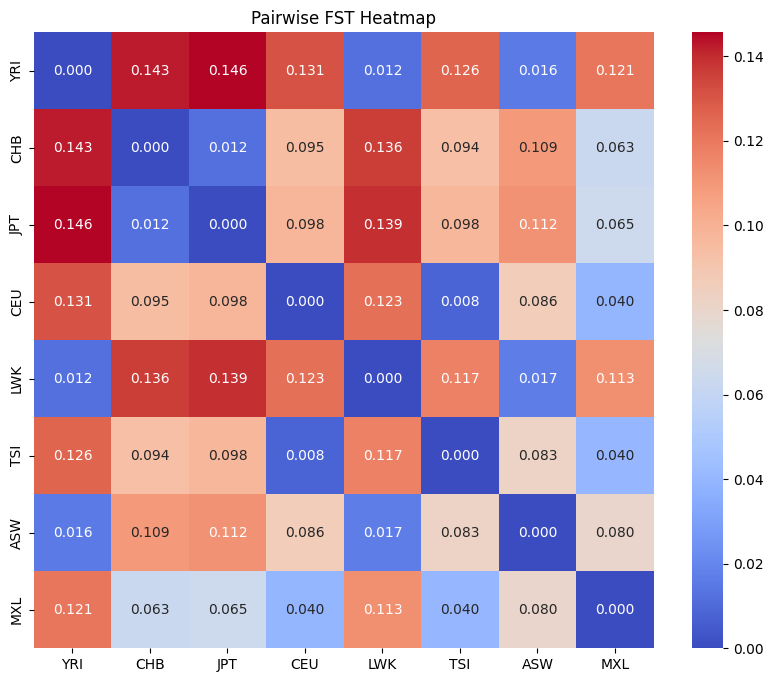

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 读取数据
data = pd.read_csv("population_fst_results.csv")

# 创建矩阵
populations = list(set(data['Population 1']).union(set(data['Population 2'])))
fst_matrix = pd.DataFrame(0, index=populations, columns=populations, dtype=float)

for _, row in data.iterrows():
    fst_matrix.loc[row['Population 1'], row['Population 2']] = row['FST']
    fst_matrix.loc[row['Population 2'], row['Population 1']] = row['FST']

# 绘制热图
plt.figure(figsize=(10, 8))
sns.heatmap(fst_matrix, annot=True, cmap="coolwarm", fmt=".3f")
plt.title("Pairwise FST Heatmap")
plt.show()


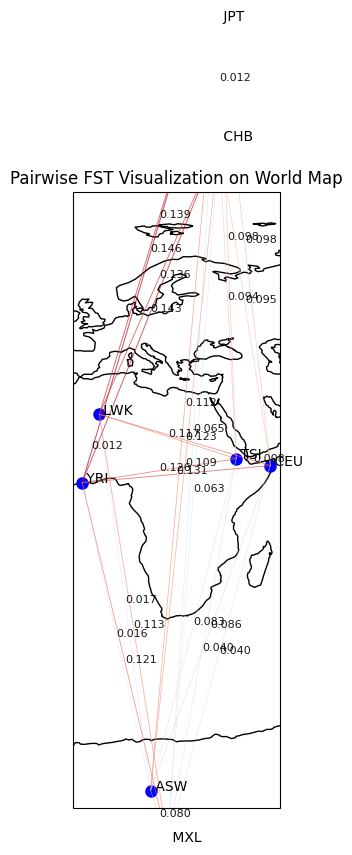

In [5]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

# 种群地理位置
pop_coords = {
    "CHB": (105, 35),
    "CEU": (10, 50),
    "YRI": (5, -5),
    "JPT": (140, 35),
    "LWK": (25, 0),
    "ASW": (-85, 15),
    "MXL": (-100, 20),
    "TSI": (12, 40)
}

# 创建地图
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

# 绘制种群位置
for pop, (lat, lon) in pop_coords.items():
    plt.plot(lon, lat, 'bo', markersize=8, transform=ccrs.PlateCarree())
    plt.text(lon, lat, f" {pop}", transform=ccrs.PlateCarree(), fontsize=10)

# 添加连线
for _, row in data.iterrows():
    pop1, pop2 = row['Population 1'], row['Population 2']
    lon1, lat1 = pop_coords[pop1][::-1]
    lon2, lat2 = pop_coords[pop2][::-1]
    fst = row['FST']
    color = plt.cm.coolwarm(fst / data['FST'].max())  # 使用颜色梯度表示 FST
    plt.plot([lon1, lon2], [lat1, lat2], color=color, transform=ccrs.PlateCarree(), alpha=0.7, lw=fst * 5)
    plt.text((lon1+lon2)/2, (lat1+lat2)/2, f"{fst:.3f}", fontsize=8, transform=ccrs.PlateCarree(), alpha=0.9)


plt.title("Pairwise FST Visualization on World Map")
plt.show()


In [4]:
import numpy as np
fst_matrix = np.array([[ 0.        , -0.00775809,  0.01533083,  0.00130738,  0.00992887,
        -0.01491489, -0.0142904 , -0.01053277],
       [-0.00775809,  0.        ,  0.02273614,  0.00892695,  0.01741671,
        -0.00704745, -0.0064325 , -0.00273229],
       [ 0.01533083,  0.02273614,  0.        , -0.01446703, -0.00557283,
        -0.03120243, -0.03055819, -0.0266817 ],
       [ 0.00130738,  0.00892695, -0.01446703,  0.        ,  0.00864409,
        -0.01626479, -0.01563867, -0.01187119],
       [ 0.00992887,  0.01741671, -0.00557283,  0.00864409,  0.        ,
        -0.02534709, -0.02470995, -0.02087619],
       [-0.01491489, -0.00704745, -0.03120243, -0.01626479, -0.02534709,
         0.        ,  0.0006064 ,  0.00425519],
       [-0.0142904 , -0.0064325 , -0.03055819, -0.01563867, -0.02470995,
         0.0006064 ,  0.        ,  0.00365322],
       [-0.01053277, -0.00273229, -0.0266817 , -0.01187119, -0.02087619,
         0.00425519,  0.00365322,  0.        ]])

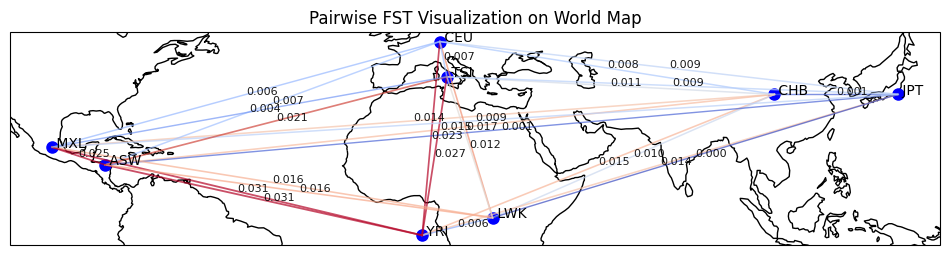

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs

# FST 矩阵
fst_matrix = np.array([
    [0.0, -0.00775809, 0.01533083, 0.00130738, 0.00992887, -0.01491489, -0.0142904, -0.01053277],
    [-0.00775809, 0.0, 0.02273614, 0.00892695, 0.01741671, -0.00704745, -0.0064325, -0.00723229],
    [0.01533083, 0.02273614, 0.0, -0.01446703, -0.00557283, -0.03120243, -0.03055819, -0.0266817],
    [0.00130738, 0.00892695, -0.01446703, 0.0, 0.0, -0.00137038, 0.00864409, -0.00857194],
    [0.00992887, 0.01741671, -0.00557283, 0.0, 0.0, -0.01626479, -0.01563867, -0.01187119],
    [-0.01491489, -0.00704745, -0.03120243, -0.00137038, -0.01626479, 0.0, -0.02534709, -0.02087619],
    [-0.0142904, -0.0064325, -0.03055819, 0.00864409, -0.01563867, -0.02534709, 0.0, 0.00425519],
    [-0.01053277, -0.00723229, -0.0266817, -0.00857194, -0.01187119, -0.02087619, 0.00425519, 0.0]
])

# 种群列表
populations = ["CHB", "CEU", "YRI", "JPT", "LWK", "ASW", "MXL", "TSI"]

# 种群坐标 (经度, 纬度)
pop_coords = {
    "CHB": (105, 35),
    "CEU": (10, 50),
    "YRI": (5, -5),
    "JPT": (140, 35),
    "LWK": (25, 0),
    "ASW": (-85, 15),
    "MXL": (-100, 20),
    "TSI": (12, 40)
}

# 创建地图
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

# 绘制种群位置
for pop, (lon, lat) in pop_coords.items():
    plt.plot(lon, lat, 'bo', markersize=8, transform=ccrs.PlateCarree())
    plt.text(lon, lat, f" {pop}", transform=ccrs.PlateCarree(), fontsize=10)

# 根据 FST 矩阵绘制种群间连线
for i, pop1 in enumerate(populations):
    for j, pop2 in enumerate(populations):
        if i < j:  # 只绘制矩阵上半部分，避免重复连线
            lon1, lat1 = pop_coords[pop1]
            lon2, lat2 = pop_coords[pop2]
            fst = np.abs(fst_matrix[i, j])
            
            # 设置颜色和线宽
            color = plt.cm.coolwarm(fst / fst_matrix.max())  # 使用颜色梯度
            lw = 1 + fst * 10  # 线宽与 FST 成正比
            
            plt.plot([lon1, lon2], [lat1, lat2], color=color, transform=ccrs.PlateCarree(), alpha=0.7, lw=lw)
            plt.text((lon1 + lon2) / 2, (lat1 + lat2) / 2, f"{fst:.3f}", fontsize=8, color='black',
                     transform=ccrs.PlateCarree(), alpha=0.9)

plt.title("Pairwise FST Visualization on World Map")
plt.show()


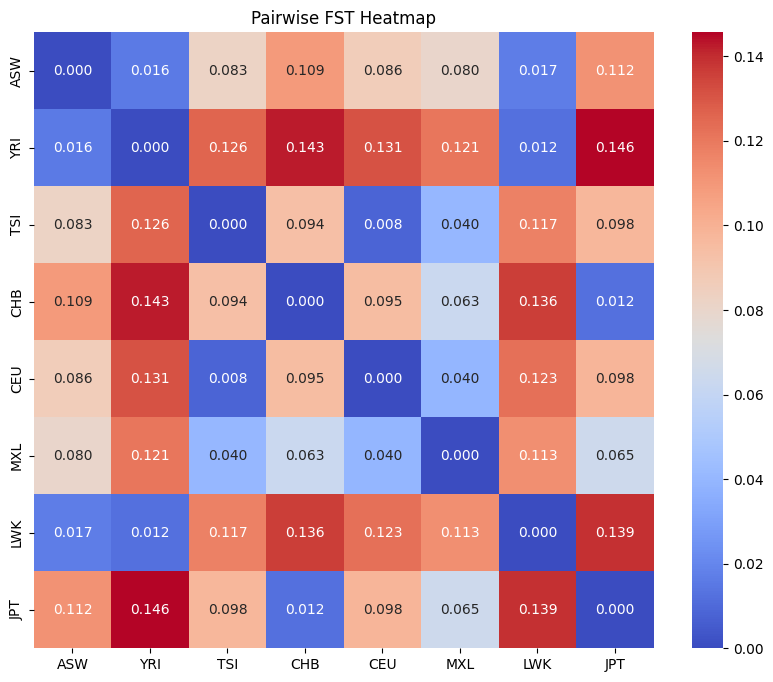

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 读取数据
data = pd.read_csv("population_fst_results.csv")

# 创建矩阵
populations = list(set(data['Population 1']).union(set(data['Population 2'])))
fst_matrix = pd.DataFrame(0, index=populations, columns=populations, dtype=float)

for _, row in data.iterrows():
    fst_matrix.loc[row['Population 1'], row['Population 2']] = row['FST']
    fst_matrix.loc[row['Population 2'], row['Population 1']] = row['FST']

# 绘制热图
plt.figure(figsize=(10, 8))
sns.heatmap(fst_matrix, annot=True, cmap="coolwarm", fmt=".3f")
plt.title("Pairwise FST Heatmap")
plt.show()


In [5]:
import pandas as pd

# 样本信息文件路径
sample_info_file = "../data/1000g/20130606_sample_info.txt"

# 读取样本信息文件
sample_info = pd.read_csv(sample_info_file, sep="\t")

# 提取属于 CEU 和 YRI 种群的样本
pop1_samples = sample_info[sample_info['Population'] == 'CEU']['Sample'].tolist()
pop2_samples = sample_info[sample_info['Population'] == 'YRI']['Sample'].tolist()

print(f"Pop1 (CEU) Samples: {pop1_samples}")
print(f"Pop2 (YRI) Samples: {pop2_samples}")


Pop1 (CEU) Samples: ['NA06984', 'NA06985', 'NA06986', 'NA06989', 'NA06991', 'NA06993', 'NA06994', 'NA06995', 'NA06997', 'NA07000', 'NA07014', 'NA07019', 'NA07022', 'NA07029', 'NA07031', 'NA07034', 'NA07037', 'NA07045', 'NA07048', 'NA07051', 'NA07055', 'NA07056', 'NA07340', 'NA07345', 'NA07346', 'NA07347', 'NA07348', 'NA07349', 'NA07357', 'NA07435', 'NA10830', 'NA10831', 'NA10835', 'NA10836', 'NA10837', 'NA10838', 'NA10839', 'NA10840', 'NA10842', 'NA10843', 'NA10845', 'NA10846', 'NA10847', 'NA10850', 'NA10851', 'NA10852', 'NA10853', 'NA10854', 'NA10855', 'NA10856', 'NA10857', 'NA10859', 'NA10860', 'NA10861', 'NA10863', 'NA10864', 'NA10865', 'NA11829', 'NA11830', 'NA11831', 'NA11832', 'NA11839', 'NA11840', 'NA11843', 'NA11881', 'NA11882', 'NA11891', 'NA11892', 'NA11893', 'NA11894', 'NA11917', 'NA11918', 'NA11919', 'NA11920', 'NA11930', 'NA11931', 'NA11932', 'NA11933', 'NA11992', 'NA11993', 'NA11994', 'NA11995', 'NA12003', 'NA12004', 'NA12005', 'NA12006', 'NA12043', 'NA12044', 'NA12045', 

In [3]:
import pandas as pd

# 加载样本信息文件
sample_info_file = "../data/1000g/20130606_sample_info.txt"
sample_info = pd.read_csv(sample_info_file, sep="\t")

# 筛选目标种群
target_population = "CEU"  # 修改为目标种群名称
sample_list = sample_info[sample_info["Population"] == target_population]["Sample"]

# 保存到文件
with open("sample_list_CEU.txt", "w") as f:
    f.write("\n".join(sample_list))


In [6]:
import subprocess

def check_missing_samples(vcf_file, sample_list_file):
    """
    检查样本列表中缺失的样本，并返回丢失样本的数量和列表。
    """
    # 获取 VCF 文件中的样本
    cmd = f"bcftools query -l {vcf_file}"
    vcf_samples = subprocess.check_output(cmd, shell=True).decode().splitlines()

    # 加载样本列表
    with open(sample_list_file, "r") as f:
        sample_list = f.read().splitlines()

    # 找出缺失的样本
    missing_samples = [sample for sample in sample_list if sample not in vcf_samples]

    print(f"Total samples in input list: {len(sample_list)}")
    print(f"Missing samples: {len(missing_samples)}")
    return missing_samples

def extract_genotypes_force_samples(vcf_file, sample_list_file, chromosome):
    """
    提取 VCF 中的基因型数据，忽略缺失的样本。
    使用 --force-samples 参数。
    """
    # 检查缺失的样本
    missing_samples = check_missing_samples(vcf_file, sample_list_file)
    if missing_samples:
        print(f"Warning: {len(missing_samples)} samples will be ignored due to absence in VCF.")

    # 提取基因型数据
    cmd = f"bcftools view -S {sample_list_file} --force-samples -r {chromosome} {vcf_file} | bcftools query -f '%POS\\t[%GT]\\n'"
    output = subprocess.check_output(cmd, shell=True, executable="/bin/bash").decode().strip().split("\n")

    # 解析输出
    positions = []
    genotypes = []
    for line in output:
        parts = line.split("\t")
        positions.append(int(parts[0]))
        snp_genotypes = [0 if gt in {"0|0", "0/0"} else
                         1 if gt in {"0|1", "1|0", "0/1", "1/0"} else
                         2 if gt in {"1|1", "1/1"} else np.nan for gt in parts[1:]]
        genotypes.append(snp_genotypes)

    print(f"Extracted {len(positions)} SNPs and {len(genotypes[0]) if genotypes else 0} samples.")
    return np.array(genotypes).T, positions

# 调用示例
def main():
    vcf_file = "../data/1000g/merged_common_snps.vcf.gz"
    sample_list_file = "sample_list_CEU.txt"
    chromosome = "2"  # 目标染色体

    # 提取基因型数据
    genotypes, positions = extract_genotypes_force_samples(vcf_file, sample_list_file, chromosome)

    # 打印一些结果以供检查
    print(f"Genotype matrix shape: {genotypes.shape}")
    print(f"First 5 SNP positions: {positions[:5]}")

if __name__ == "__main__":
    main()


Total samples in input list: 183
Missing samples: 84
Extracted 2152 SNPs and 1 samples.
Genotype matrix shape: (1, 2152)
First 5 SNP positions: [23163, 45283, 92227, 96409, 113750]


Warn: subset called for sample that does not exist in header: "NA06991"... skipping
Warn: subset called for sample that does not exist in header: "NA06993"... skipping
Warn: subset called for sample that does not exist in header: "NA06995"... skipping
Warn: subset called for sample that does not exist in header: "NA06997"... skipping
Warn: subset called for sample that does not exist in header: "NA07014"... skipping
Warn: subset called for sample that does not exist in header: "NA07019"... skipping
Warn: subset called for sample that does not exist in header: "NA07022"... skipping
Warn: subset called for sample that does not exist in header: "NA07029"... skipping
Warn: subset called for sample that does not exist in header: "NA07031"... skipping
Warn: subset called for sample that does not exist in header: "NA07034"... skipping
Warn: subset called for sample that does not exist in header: "NA07045"... skipping
Warn: subset called for sample that does not exist in header: "NA07055"... s

In [8]:
import gzip

def parse_vcf(vcf_file):
    genotypes = []
    chromosomes = []
    positions = []

    with gzip.open(vcf_file, 'rt') as f:  # 注意这里使用 'rt' 以文本模式读取 gzip 文件
        for line in f:
            if line.startswith("#"):  # 跳过注释行
                continue
            fields = line.strip().split("\t")
            chromosomes.append(fields[0])  # 染色体
            positions.append(fields[1])  # 位点
            genotype_info = fields[9:]  # 获取所有样本的基因型信息
            genotype_row = []

            for gt in genotype_info:
                if gt.startswith("0/0"):
                    genotype_row.append(0)  # 纯合野生型
                elif gt.startswith("0/1") or gt.startswith("1/0"):
                    genotype_row.append(1)  # 杂合
                elif gt.startswith("1/1"):
                    genotype_row.append(2)  # 纯合突变型
                else:
                    genotype_row.append(-1)  # 缺失值

            genotypes.append(genotype_row)

    return chromosomes, positions, genotypes
vcf_file = "../data/1000g/merged_common_snps.vcf.gz"
chromosomes, positions, genotypes = parse_vcf(vcf_file)
print(f"提取到 {len(positions)} 个SNP，基因型矩阵大小为：{len(genotypes)} x {len(genotypes[0])}")

提取到 26395 个SNP，基因型矩阵大小为：26395 x 745


In [12]:
for row in genotypes[:5]:
    print(row)
with gzip.open(vcf_file, "rt") as f:
    for line in f:
        if not line.startswith("#"):  # 跳过头部
            fields = line.strip().split("\t")
            print(fields[9:15])  # 打印前几个样本的基因型字段
            break

[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,

In [19]:
with open("mutual_snps.txt", "r") as f:
    mutual_snps = set(line.strip() for line in f)  # 读取并去掉换行符
import gzip

def parse_vcf_with_snps(vcf_file, mutual_snps):
    genotypes = []
    with gzip.open(vcf_file, "rt") as f:
        for line in f:
            if line.startswith("#"):  # 跳过注释行
                continue
            fields = line.strip().split("\t")
            chrom, pos, _, _, _ = fields[:5]  # 提取染色体和位置
            snp_key = f"{chrom}:{pos}"       # 生成 key，例如 "1:742584"
            if snp_key in mutual_snps:       # 检查是否在 mutual_snps 中
                genotype_data = fields[9:]   # 提取基因型字段
                genotypes.append(genotype_data)
    return genotypes
vcf_file = "../data/1000g/merged_common_snps.vcf.gz"
genotypes = parse_vcf_with_snps(vcf_file, mutual_snps)

print(f"提取到 {len(genotypes)} 个 SNP 的基因型数据。")
print("示例基因型数据：", genotypes[:3])  # 打印前 3 行基因型数据


提取到 21526 个 SNP 的基因型数据。
示例基因型数据： [['1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '0|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '0|1', '0|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1', '1|1',

In [20]:
# 检查 mutual_snps 的内容
print(list(mutual_snps)[:10])  # 打印前 10 个 SNP

# 检查 VCF 文件的前几行
with gzip.open(vcf_file, "rt") as f:
    for line in f:
        if not line.startswith("#"):
            fields = line.strip().split("\t")
            chrom, pos = fields[0], fields[1]
            print(f"{chrom}:{pos}")  # 打印 VCF 文件中的染色体:位置
            break


['12:29348817', '1:87635175', '15:57110121', '4:187951685', '9:15903849', '10:8678107', '20:4524230', '1:65697937', '10:2281632', '3:71195250']
10:319493


In [23]:
matched_snps = 0
with gzip.open(vcf_file, "rt") as f:
    for line in f:
        if line.startswith("#"):  # 跳过头部
            continue
        fields = line.strip().split("\t")
        chrom, pos = fields[0], fields[1]
        snp_key = f"{chrom}:{pos}"
        if snp_key in mutual_snps:  # 匹配 SNP
            matched_snps += 1

print(f"匹配到 {matched_snps} 个 SNP")
with gzip.open(vcf_file, "rt") as f:
    for line in f:
        if line.startswith("#"):  # 跳过头部
            continue
        fields = line.strip().split("\t")
        chrom, pos = fields[0], fields[1]
        snp_key = f"{chrom}:{pos}"
        if snp_key in mutual_snps:  # 打印匹配的 SNP
            print(snp_key)
            break  # 只打印第一个匹配的 SNP


匹配到 21526 个 SNP
10:319493


In [24]:
# 提取基因型矩阵
genotypes = []
with gzip.open(vcf_file, "rt") as f:
    for line in f:
        if line.startswith("#"):  # 跳过头部
            continue
        fields = line.strip().split("\t")
        chrom, pos = fields[0], fields[1]
        snp_key = f"{chrom}:{pos}"
        if snp_key in mutual_snps:  # 仅处理匹配的SNP
            genotype_row = []
            for gt in fields[9:]:
                if gt.startswith("0/0") or gt.startswith("0|0"):
                    genotype_row.append(0)
                elif gt.startswith("0/1") or gt.startswith("0|1") or gt.startswith("1/0") or gt.startswith("1|0"):
                    genotype_row.append(1)
                elif gt.startswith("1/1") or gt.startswith("1|1"):
                    genotype_row.append(2)
                else:
                    genotype_row.append(-1)  # 缺失值
            genotypes.append(genotype_row)

# 将基因型矩阵保存为文本文件
output_file = "genotype_matrix.txt"
with open(output_file, "w") as f:
    for row in genotypes:
        f.write("\t".join(map(str, row)) + "\n")

print(f"基因型矩阵已保存到 {output_file}")


基因型矩阵已保存到 genotype_matrix.txt


In [25]:
with open(output_file, "r") as f:
    for i, line in enumerate(f):
        print(line.strip())
        if i >= 5:  
            break

2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	1	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	1	1	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	1	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	1	2	2	2	2	2	1	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	1	2	2	2	1	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	1	2	2	2	2	2	2	2	2	2	2	1	1	2	2	1	1	2	1	2	1	2	1	2	2	2	2	2	2	2	2	1	2	2	2	2	2	2	1	2	2	2	1	2	2	2	2	2	2	1	2	2	2	2	1	2	2	2	2	2	2	2	2	2	2	2	1	2	2	2	1	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	1	2	2	1	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	1	2	2	2	2	2	2	2	2	2	2	2	2	2	2	

In [31]:
with gzip.open(vcf_file, "rt") as f:
    for line in f:
        if line.startswith("#"):
            continue
        fields = line.strip().split("\t")
        chrom, pos = fields[0], fields[1]
        snp_key = f"{chrom}:{pos}"
        if snp_key in mutual_snps:

            print(fields[9:20])  
            break
            
with gzip.open(vcf_file, "rt") as f:
    snps_in_vcf = set()
    for line in f:
        if line.startswith("#"):
            continue
        fields = line.strip().split("\t")
        snps_in_vcf.add(f"{fields[0]}:{fields[1]}")

missing_snps = mutual_snps - snps_in_vcf
print(f"Missing SNPs: {len(missing_snps)}")
print(list(missing_snps)[:10])  


['0|1', '0|0', '1|0', '0|0', '1|0', '0|1', '1|0', '1|0', '1|0', '1|0', '0|0']
Missing SNPs: 0
[]


In [36]:
def compare_genotypes(vcf_file, geno_file):
    # 读取 VCF 文件
    with open(vcf_file, 'r') as f:
        vcf_lines = f.readlines()
    
    # 读取 .geno 文件
    with open(geno_file, 'r') as f:
        geno_lines = f.readlines()
    
    # 确保行数匹配
    assert len(vcf_lines) == len(geno_lines), f"Mismatch in number of SNPs: {len(vcf_lines)} vs {len(geno_lines)}"
    
    # 比较基因型数据
    for i, (vcf_line, geno_line) in enumerate(zip(vcf_lines, geno_lines)):
        vcf_fields = vcf_line.strip().split('\t')
        geno_values = geno_line.strip()
        
        chrom_pos = f"{vcf_fields[0]}:{vcf_fields[1]}"  # 获取染色体位置
        vcf_genotypes = vcf_fields[2:]  # 从第三列开始是基因型
        
        # 将 VCF 中的基因型转换为相应的代码（0, 1, 2）
        vcf_codes = []
        for gt in vcf_genotypes:
            if gt == '0|0' or gt == '0/0':
                vcf_codes.append('0')
            elif gt == '0|1' or gt == '1|0' or gt == '0/1' or gt == '1/0':
                vcf_codes.append('1')
            elif gt == '1|1' or gt == '1/1':
                vcf_codes.append('2')
            else:
                vcf_codes.append('9')  # 缺失值
        
        # 比较 VCF 和 .geno 文件的基因型
        geno_codes = list(geno_values.strip())  # 转换为字符列表
        if vcf_codes != geno_codes:
            print(f"Mismatch at SNP {chrom_pos}")
        else:
            print(f"Match at SNP {chrom_pos}")

# 文件路径
vcf_file = "../data/1000g/extracted_genotypes.txt"
geno_file = "../data/1000g/converted/CHB.geno"

compare_genotypes(vcf_file, geno_file)


Match at SNP 10:319493
Match at SNP 10:414200
Match at SNP 10:1064152
Match at SNP 10:1071882
Match at SNP 10:1178555
Match at SNP 10:1214336
Match at SNP 10:1225393
Match at SNP 10:1493564
Match at SNP 10:1508682
Match at SNP 10:1578114
Match at SNP 10:1581836
Match at SNP 10:1631165
Match at SNP 10:1632998
Match at SNP 10:1655794
Match at SNP 10:1655821
Match at SNP 10:1671656
Match at SNP 10:1735254
Match at SNP 10:1737749
Match at SNP 10:1749201
Match at SNP 10:1935387
Match at SNP 10:1984789
Match at SNP 10:2035987
Match at SNP 10:2038903
Match at SNP 10:2094415
Match at SNP 10:2207847
Match at SNP 10:2215271
Match at SNP 10:2227597
Match at SNP 10:2246731
Match at SNP 10:2279752
Match at SNP 10:2281632
Match at SNP 10:2282684
Match at SNP 10:2480169
Match at SNP 10:2480169
Match at SNP 10:2521999
Match at SNP 10:2561838
Match at SNP 10:2614963
Match at SNP 10:2688812
Match at SNP 10:2690830
Match at SNP 10:2705742
Match at SNP 10:2743736
Match at SNP 10:2745927
Match at SNP 10:27

In [37]:
import numpy as np
import pandas as pd

# 假设你已经把 CHB 的 .geno 文件读取为 numpy 数组
geno_array = np.loadtxt("../data/1000g/converted/CHB.geno", dtype=int)

# 读取 .ind 文件，获得样本信息（如果需要）
ind_data = pd.read_csv("../data/1000g/converted/CHB.ind", sep="\t", header=None, names=["sample", "sex", "pop"])
print(ind_data.head())

# 读取 .snp 文件，获得 SNP 信息（如果需要）
snp_data = pd.read_csv("../data/1000g/converted/CHB.snp", sep="\t", header=None, names=["chromosome", "position", "ref", "alt", "morgans"])
print(snp_data.head())


    sample sex  pop
0  NA06984   U  CHB
1  NA06985   U  CHB
2  NA06986   U  CHB
3  NA06989   U  CHB
4  NA06994   U  CHB
   chromosome  position ref    alt  morgans
0          10    319493   C      G      0.0
1          10    414200   T      C      0.0
2          10   1064152   G  <CN0>      0.0
3          10   1071882   C      T      0.0
4          10   1178555   G      A      0.0


/tmp/ipykernel_896159/2998724218.py:5: DeprecationWarning: loadtxt(): Parsing an integer via a float is deprecated.  To avoid this warning, you can:
    * make sure the original data is stored as integers.
    * use the `converters=` keyword argument.  If you only use
      NumPy 1.23 or later, `converters=float` will normally work.
    * Use `np.loadtxt(...).astype(np.int64)` parsing the file as
      floating point and then convert it.  (On all NumPy versions.)
  (Deprecated NumPy 1.23)
  geno_array = np.loadtxt("../data/1000g/converted/CHB.geno", dtype=int)


In [43]:
print(geno_array.shape)
geno_array = np.array(geno_array)  # 如果它还是列表，可以转换为 numpy 数组
geno_array = geno_array.reshape(-1, 1)  # 将其转换为 2D 数组
print(geno_array.shape)

(26395, 1)
(26395, 1)


In [44]:
from sklearn.preprocessing import StandardScaler

# 假设基因型数据是按样本和 SNP 排列的矩阵，进行标准化
scaler = StandardScaler()
scaled_geno_array = scaler.fit_transform(geno_array)


In [50]:
import pandas as pd

# 读取 .ind 文件，假设文件格式为：sample_name, sex, pop
ind_data = pd.read_csv('../data/1000g/converted/CHB.ind', sep='\t', header=None, names=['sample', 'sex', 'pop'])

# 打印元数据，确保样本标签和群体信息正确
print(ind_data.head())

# 将样本标签加入 geno_array 以便在 PCA 中使用
samples = ind_data['pop'].values  # 假设 'pop' 列包含群体信息


    sample sex  pop
0  NA06984   U  CHB
1  NA06985   U  CHB
2  NA06986   U  CHB
3  NA06989   U  CHB
4  NA06994   U  CHB


In [47]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 进行 PCA 分析
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_geno_array)

# 绘制 PCA 结果
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.7, edgecolors='k')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of CHB Genotype Data')
plt.show()

# 打印主成分的方差比例
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")


ValueError: n_components=2 must be between 0 and min(n_samples, n_features)=1 with svd_solver='covariance_eigh'

In [46]:
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 8.3 MB 5.3 MB/s            
     |████████████████████████████████| 1.6 MB 112.6 MB/s            
     |████████████████████████████████| 321 kB 152.3 MB/s            
     |████████████████████████████████| 4.4 MB 47.4 MB/s            
     |████████████████████████████████| 4.6 MB 53.6 MB/s            


In [29]:
import gzip

# 修复后的解析和过滤逻辑
def parse_vcf_correctly(vcf_file, mutual_snps):
    genotypes = []
    with gzip.open(vcf_file, "rt") as f:
        for line in f:
            if line.startswith("#"):  # 跳过头部信息
                continue
            fields = line.strip().split("\t")
            chrom, pos = fields[0], fields[1]
            snp_key = f"{chrom}:{pos}"
            if snp_key in mutual_snps:
                genotype_data = fields[9:]  # 获取所有样本的GT字段
                genotypes.append(genotype_data)
    return genotypes

# 检查输出
vcf_file = "../data/1000g/filtered.chr1.phase3.vcf.gz"
mutual_snps = {"1:10177", "1:10235", "1:10352"}  # 示例SNP列表，实际用你的 mutual_snps.txt 加载
genotypes = parse_vcf_correctly(vcf_file, mutual_snps)

# 打印输出确认
for row in genotypes[:5]:  # 打印前5个结果
    print(row)


['0|1', '0|0', '1|0', '0|0', '1|0', '0|1', '1|0', '1|0', '1|0', '1|0', '0|0', '0|1', '1|0', '0|0', '0|0', '0|0', '0|0', '1|0', '0|1', '0|0', '1|1', '1|0', '1|0', '1|1', '0|0', '0|0', '0|0', '1|0', '0|1', '1|0', '1|1', '1|0', '0|1', '0|1', '0|1', '0|1', '0|1', '0|1', '0|1', '0|1', '1|0', '1|0', '1|0', '0|1', '0|1', '1|0', '1|0', '0|0', '0|1', '1|0', '1|0', '0|1', '0|0', '1|0', '0|1', '0|1', '0|0', '0|0', '0|1', '1|0', '1|0', '1|0', '0|0', '0|1', '1|0', '1|0', '0|1', '0|1', '1|1', '0|1', '1|0', '0|0', '1|1', '0|1', '0|0', '0|1', '1|0', '1|0', '0|1', '1|0', '1|0', '1|0', '0|1', '0|1', '1|1', '1|0', '0|1', '0|1', '0|1', '0|1', '1|0', '1|1', '1|0', '0|1', '0|1', '0|1', '0|1', '0|1', '1|0', '1|1', '1|0', '1|0', '1|0', '0|1', '0|0', '0|1', '0|1', '0|1', '1|0', '1|0', '1|0', '0|1', '0|1', '0|1', '0|1', '0|1', '1|1', '0|1', '1|0', '1|0', '0|1', '1|0', '1|0', '0|1', '1|0', '0|0', '0|0', '0|0', '0|1', '1|0', '1|0', '0|0', '0|0', '0|0', '1|0', '0|0', '0|0', '0|0', '0|0', '0|0', '0|1', '1|0', '0|1'

In [18]:
def parse_vcf(vcf_file):
    chromosomes = []
    positions = []
    genotypes = []
    
    with gzip.open(vcf_file, "rt") as f:
        for line in f:
            if not line.startswith("#"):  # 跳过头部
                fields = line.strip().split("\t")
                snp_id = fields[2]
                chromosome = fields[0]
                position = fields[1]
                genotype_info = fields[9:]  # 获取所有样本的基因型字段
                
                chromosomes.append(chromosome)
                positions.append(position)

                genotype_row = []
                for gt in genotype_info:
                    if gt == "0/0":
                        genotype_row.append(0)
                    elif gt == "0/1":
                        genotype_row.append(1)
                    elif gt == "1/1":
                        genotype_row.append(2)
                    else:
                        genotype_row.append(-1)  # 缺失值
                genotypes.append(genotype_row)
    
    return chromosomes, positions, genotypes


In [9]:
import numpy as np

genotypes_array = np.array(genotypes)
missing_count = np.sum(genotypes_array == -1)
total_count = genotypes_array.size
missing_ratio = missing_count / total_count

print(f"基因型矩阵中缺失值数量：{missing_count}")
print(f"缺失值比例：{missing_ratio:.2%}")
from collections import Counter

chromosome_counts = Counter(chromosomes)
print("各染色体上的SNP分布：")
for chrom, count in sorted(chromosome_counts.items(), key=lambda x: int(x[0])):
    print(f"染色体 {chrom}: {count} 个 SNP")


基因型矩阵中缺失值数量：19664275
缺失值比例：100.00%
各染色体上的SNP分布：
染色体 1: 1859 个 SNP
染色体 2: 2152 个 SNP
染色体 3: 1801 个 SNP
染色体 4: 1672 个 SNP
染色体 5: 1652 个 SNP
染色体 6: 1715 个 SNP
染色体 7: 1395 个 SNP
染色体 8: 1711 个 SNP
染色体 9: 1324 个 SNP
染色体 10: 1380 个 SNP
染色体 11: 1414 个 SNP
染色体 12: 1245 个 SNP
染色体 13: 932 个 SNP
染色体 14: 827 个 SNP
染色体 15: 767 个 SNP
染色体 16: 1079 个 SNP
染色体 17: 793 个 SNP
染色体 18: 757 个 SNP
染色体 19: 465 个 SNP
染色体 20: 691 个 SNP
染色体 21: 402 个 SNP
染色体 22: 362 个 SNP
